# Отток клиентов

**Задача**: 
Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.
Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 
Постройте модель с предельно большим значением F1-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте F1-меру на тестовой выборке самостоятельно.
Дополнительно измеряйте AUC-ROC, сравнивайте её значение с F1-мерой.

**План выполнения работы**:
* Загрузить и подготовить данные.
* Исследовать баланс классов и обучить модель без учёта дисбаланса. 
* Улучшить качество модели, учитывая дисбаланс классов. 
* Обучить разные модели и найти лучшую. 
* Провести финальное тестирование. 

## 1. Чтение исходных данных

**Импорт основных библиотек**

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import random
import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import (
    accuracy_score, 
    f1_score, 
    precision_score, 
    recall_score, 
    roc_curve, 
    roc_auc_score, 
    auc)

from sklearn.utils import shuffle

import warnings

#!pip install imblearn
#from imblearn.over_sampling import SMOTE

## 1.1 Чтение исходного датесета

In [2]:
try:
    data = pd.read_csv('/datasets/Churn.csv')
except:
    base_root = 'D:/Docs/Yandex_Practikum/projects/'
    data = pd.read_csv(base_root + '/datasets/Churn.csv')

## 1.2 Вывод основной информации о датасете

### 1.2.1 Функция для вывода основной информации о датасете и первых строк

In [3]:
def dataset_main_info(data):
    """
    функция предназначена для вывода основной описательной информации о датасете.
    на сход функции передается датасет
    функция выводит на экран следующую информацию:
    1. описательную информацию о датасете
    2. количество стррок и столбцов в датасете
    3. количестсво пропущенных значений
    4. количество дубликатов
    5. названия столбцов
    6. первые 5 строк датасета
    """
    
    print('1. Описание датасета')
    print(data.info())
    print()
    print('2. Размерность датасета')
    print(f'Датасет состоит из {data.shape[0]} строк и {data.shape[1]} столбцов')
    print()
    print('3. Количество пропущенных значений', data.isna().sum() )
    print()
    print('4. Количество дубликатов - ', data.duplicated().sum(), '. Процент дубликатов в объеме исходных данных - ', 
          round(data.duplicated().sum() / data.shape[0]*100, 2), " %.")
    print()
    print('5. Название столбцов')
    print(data.columns)
    print()
    print('6. Первые 5-ть строк датасета')
    return  data.head()

### 1.2.2 Вывод основной информации о датасете

In [4]:
dataset_main_info(data)

1. Описание датасета
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB
None

2. Размерность датасета
Датасет состоит из 10000 строк и 14 столбцо

RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0          1    15634602  Hargrave          619    France  Female   42   
1          2    15647311      Hill          608     Spain  Female   41   
2          3    15619304      Onio          502    France  Female   42   
3          4    15701354      Boni          699    France  Female   39   
4          5    15737888  Mitchell          850     Spain  Female   43   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0     2.0       0.00              1          1               1   
1     1.0   83807.86              1          0               1   
2     8.0  159660.80              3          1               0   
3     1.0       0.00              2          0               0   
4     2.0  125510.82              1          1               1   

   EstimatedSalary  Exited  
0        101348.88       1  
1        112542.58       0  
2        113931.57       1  
3         93826.63       0  
4         79084.10       0

**Промежуточный вывод:**
1. Датасет состоит из 10 000 строк и 14 столбцов;
2. В датасете отсутствуют дибликаты.
3. Названия столбцов - 'RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited':

*Название столбцов*
- RowNumber — индекс строки в данных
- CustomerId — уникальный идентификатор клиента
- Surname — фамилия
- CreditScore — кредитный рейтинг
- Geography — страна проживания
- Gender — пол
- Age — возраст
- Tenure — сколько лет человек является клиентом банка
- Balance — баланс на счёте
- NumOfProducts — количество продуктов банка, используемых клиентом
- HasCrCard — наличие кредитной карты
- IsActiveMember — активность клиента
- EstimatedSalary — предполагаемая зарплата
- Exited — факт ухода клиента

Для  анализа в качестве признаков выберем следующие столбцы:
'CreditScore', 'Geography','Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard','IsActiveMember', 'EstimatedSalary'.

*Целевой признак*
Exited — факт ухода клиента

4. В столбце "Tenure"(количество лет в течении, которых человек является клиентом банка) пропущено 909 записей. Ввведм гипотезу, что если запись пропущена, то человек ранее не являлся клиентом банка и заполним пропуски - нулями.

5. Значения в столбцах "Geography" (страна проживания) и "Gender" (пол) требует дополнительной обработки кодирование строковых значений числовыми.

6. Значения в столбцах 'CreditScore', 'Balance', 'EstimatedSalary' требуют исследования и, возможно, нормироваки, т.к. могут встречаться значения, которые сильно различаются, что може исказить коэффициенты будущей модели.

Парные графики


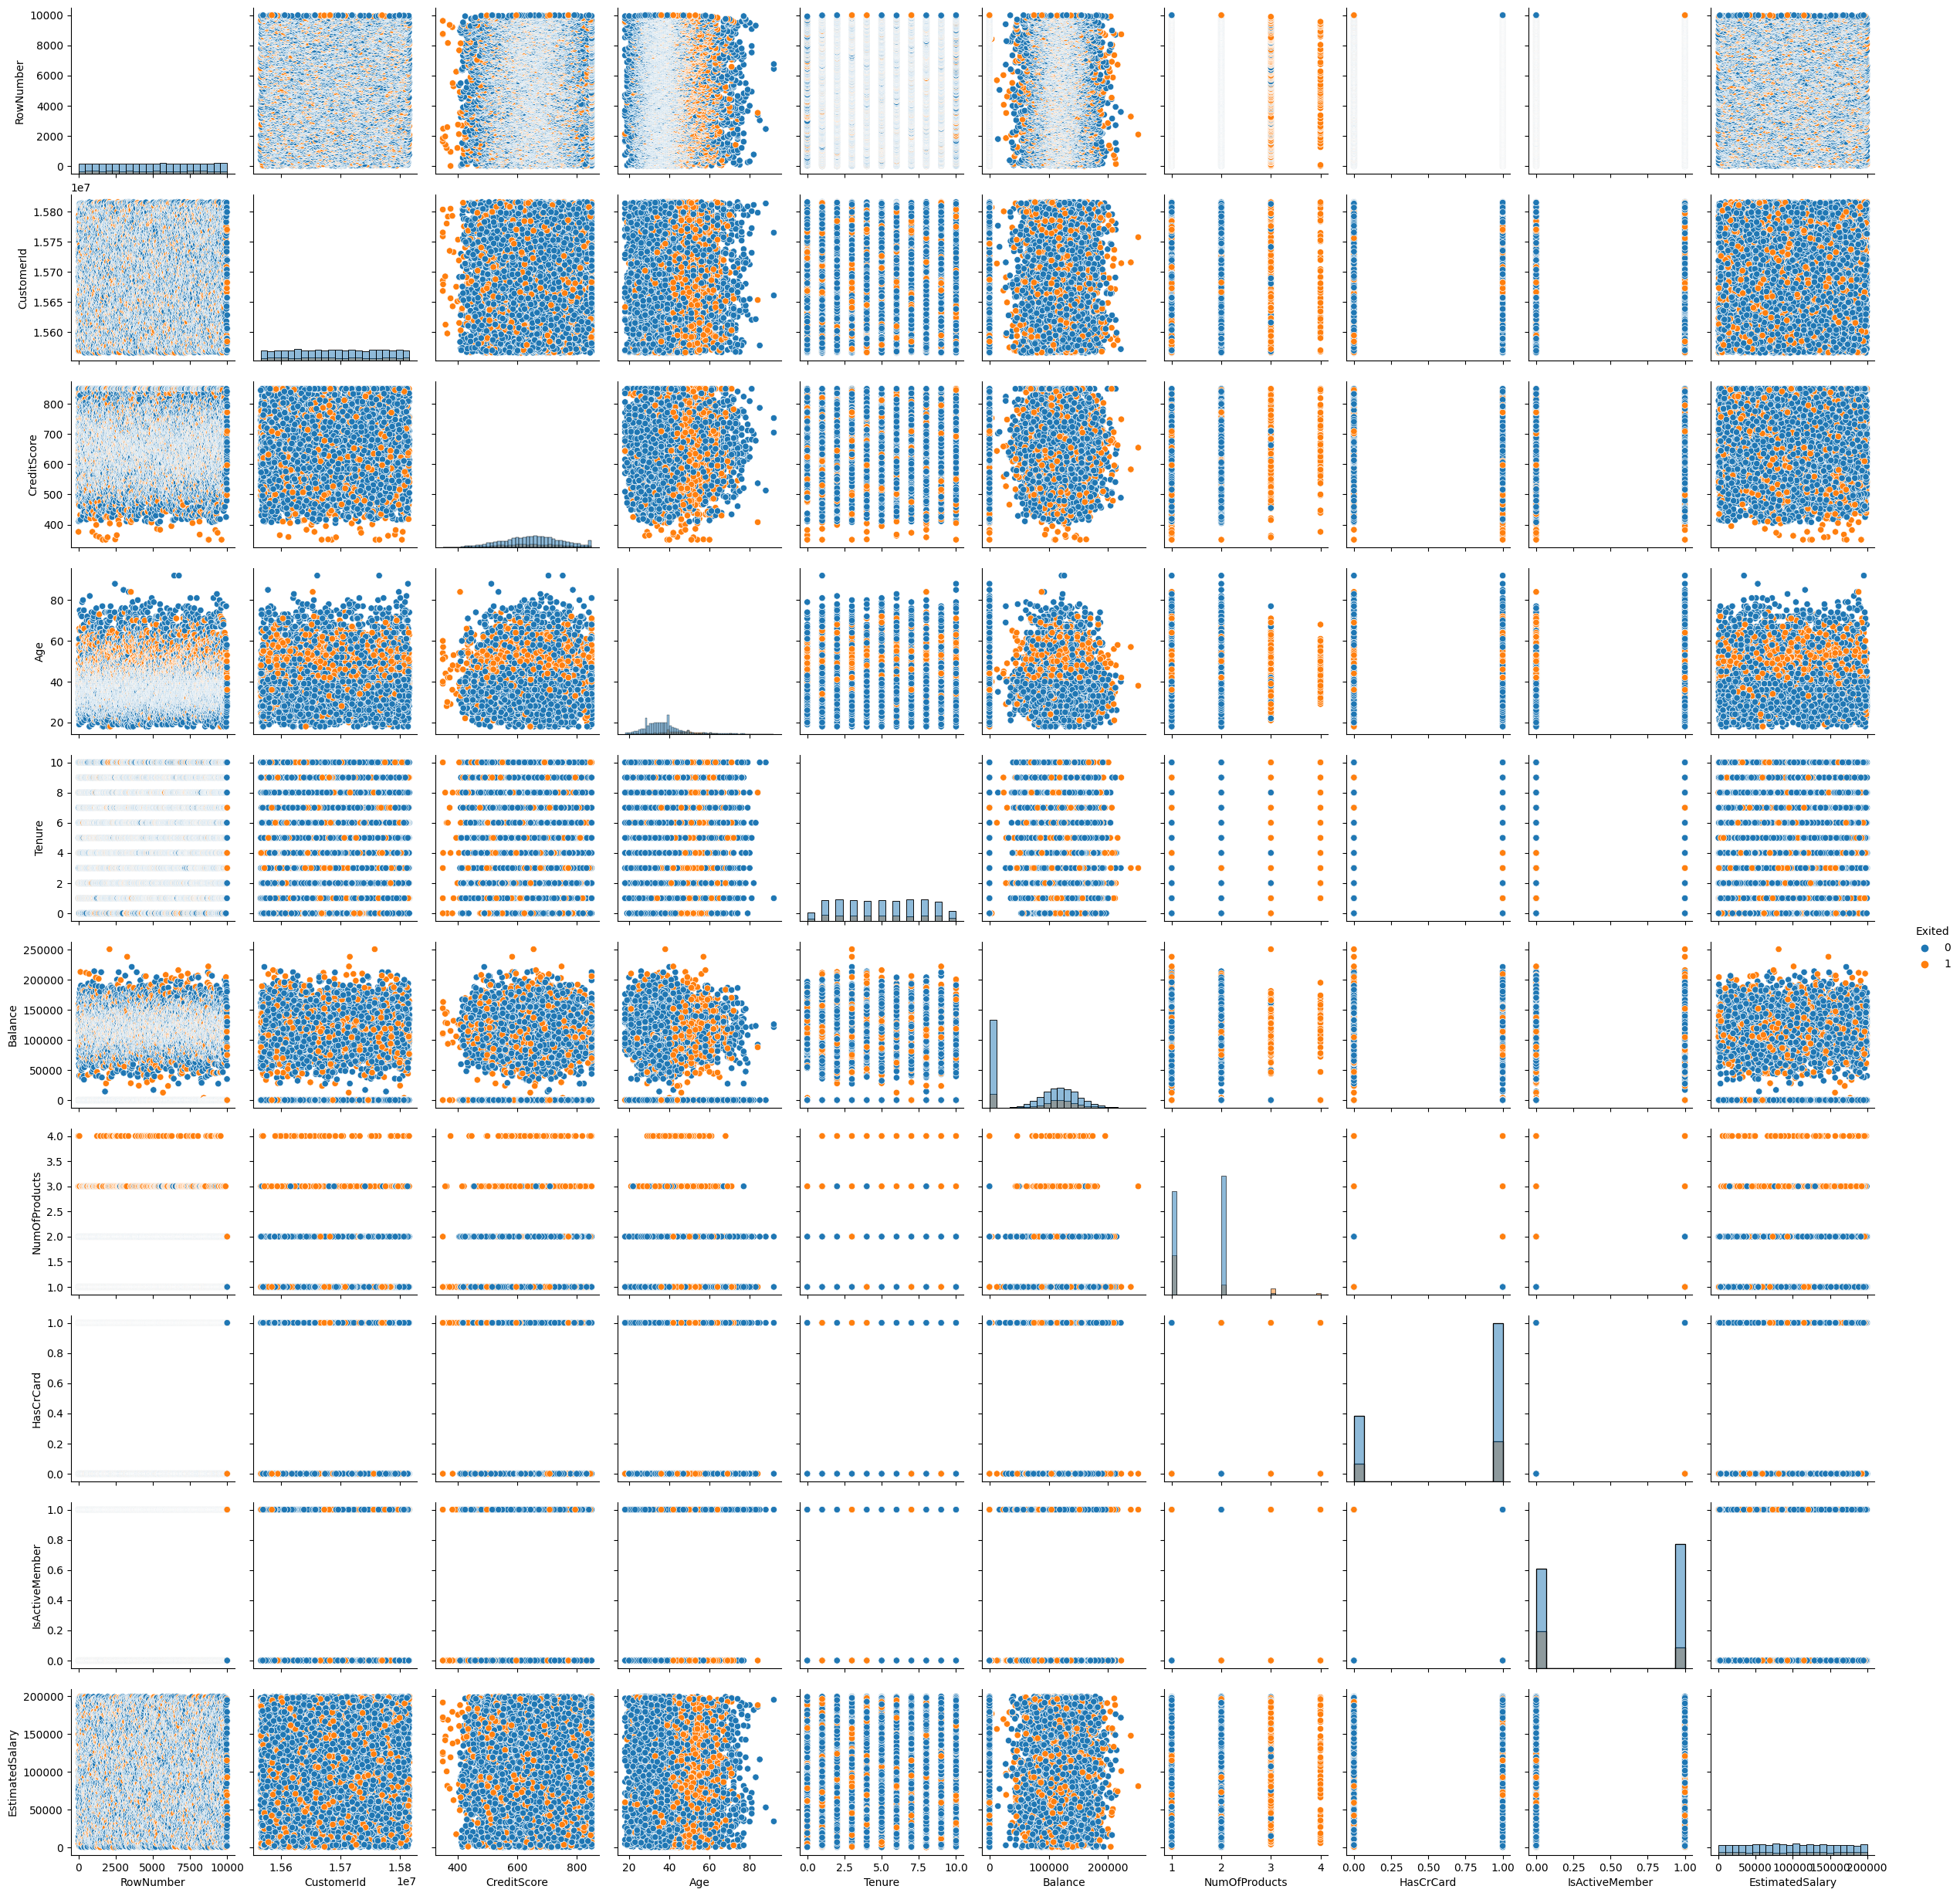

In [5]:
print('Парные графики')
sns.pairplot(data, hue = 'Exited', diag_kind="hist");

**Примечание:** Из анализа графиков сложно выделить начилие корреляций между столбцами датасета. Хотя можно отметить разделения по классам данных для ряда графиков:
- CreditScore vs. NumberOfProducts
- CreditScore vs. Tenure
- CreditScore vs. EstimateSalary

Рассмотрим более подробно данные каждого столбца

### 1.2.3 Графическое отображение данных датасета

#### 1.2.3.1 Функция для построение гистограммы

In [6]:
def hist_drawing(data, name, bins_number, flag):
    print("Гистограмма распределения")
    #data[name].hist(bins = bins_number)
    sns.histplot(data=data, x=name, color="skyblue", label=name, kde=True, hue = flag, alpha = 0.5)
    name_of_plot = "Гистограмма распределения для столбца " + name
    plt.title(name_of_plot, fontsize = 18)
    plt.xlabel(name, fontsize = 14)
    plt.ylabel('Количество пользователей', fontsize = 14)  

    #plt.legend(flag) 

    plt.show()

#### 1.2.3.2 Функция для построениея диаграммы ящик с усами

In [7]:
def boxplot_diagram_drawing(data, name):
    name_of_plot = "Диаграммы ящик с усами для столбца " + name
    print(name_of_plot)
    data.boxplot(name, vert=False, figsize = (10, 3))
    plt.title(name_of_plot, fontsize = 18)
    plt.xlabel(name,fontsize = 14)
    plt.show()
    
    iqr_value = st.iqr(data[name])
    percentage_25 = data[name].quantile(0.25)
    percentage_75 = data[name].quantile(0.75)
    # граница левого уса
    lower_whisker = percentage_25 - 1.5 * iqr_value
    if lower_whisker < 0:
        lower_whisker = 0
    # количество элементов попавщих ниже левого уса
    num_lower_left_edge = data.loc[data[name] < lower_whisker, name].count()
    # граница правого уса
    upper_whisker = percentage_75 + 1.5 * iqr_value
    # количество элементов попавщих выше правого уса
    num_higher_right_edge = data.loc[data[name] > upper_whisker, name].count()
    
    print("Граница левого уса - ", lower_whisker)
    print("Количество элементов расположенных ниже левого уса - ", num_lower_left_edge)
    print()
    print("Граница правого уса - ", upper_whisker)
    print("Количество элементов расположенных выше правого уса - ", num_higher_right_edge)
    print()
    return [lower_whisker, num_lower_left_edge, upper_whisker, num_higher_right_edge]

#### 1.2.3.3. Функция для вычисления ассиметрии распределения

In [8]:
def skewness_value(data):
    skewness = round(st.skew(data),2)
    #print(skewness)
    if skewness > 0:
        #print('Распределение смещено влево')
        message = 'Распределение смещено влево'
    else:
        #print('Распределение смещено в право')
        message = 'Распределение смещено в право'
    return [skewness, message]

#### 1.2.3.4 Функция для отображения основной графической информации

In [9]:
def main_stat_info(data, name, bins_number, flag):
    """
    функция предназначена для вывода на экран основной статистической информации по выборке, 
    а также отображению статистических графиков: гистограммы, ящика с усами.
    """
    #0. вывод название столбца
    print('Столбец: ',name)
    print()
    
    #1. вывод основной описательной статистики"
    print("Описательная статистика")
    print(data[name].describe())
    print()
    
    skewness_val = skewness_value(data[name])[0]
    skewness_message = skewness_value(data[name])[1]
    print()
    
    #3. построение гистограммы распределения"
    hist_drawing(data, name, bins_number, flag)
    
    #4. построение диаграммы ящик с усами"
    boxplot_diagram_drawing(data, name)[0]
    
    if name == 'CreditScore':
        dimension = 'CreditScore'
    elif name == 'Age':
        dimension = 'Age'
    elif name == 'Tenure':
        dimension = 'Tenure'
    elif name == 'Balance':
        dimension = 'Balance' 
    else:
        dimension = 'EstimatedSalary'
    
    
    print('!'*10)
    print('Промежуточный вывод:')
    print('Столбец: ', name)   
    print(f'1.1. Среднее количество {dimension} = {round(data[name].mean(),2)}, тогда как медианное значение равно = {round(data[name].median(),2)}.') 
    print(f'1.2. Минимальное количество {dimension} равно - {round(data[name].min(),2)}, максимальнок количество {dimension} равно - {round(data[name].max(),2)}')
    print(f'1.3. Коэффициент ассиметрии равен - {skewness_val}, следовательно, {skewness_message}')
    print()
    print("*"*100)
    print()

### 1.2.3.5 Описательная статистика и основная информация для столбцов с количественными данными

In [10]:
data_columns_name = ['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary']
data_columns_name

['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary']

#### 1.2.3.5 Вывод информации о данных датасета в графическом формате

Столбец:  CreditScore

Описательная статистика
count    10000.000000
mean       650.528800
std         96.653299
min        350.000000
25%        584.000000
50%        652.000000
75%        718.000000
max        850.000000
Name: CreditScore, dtype: float64


Гистограмма распределения


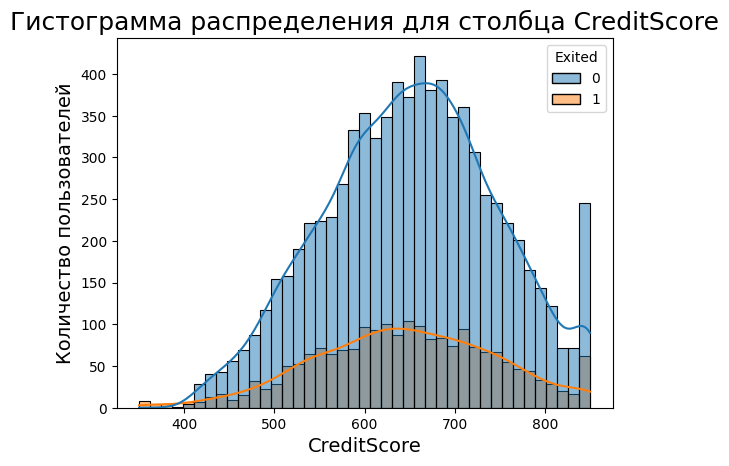

Диаграммы ящик с усами для столбца CreditScore


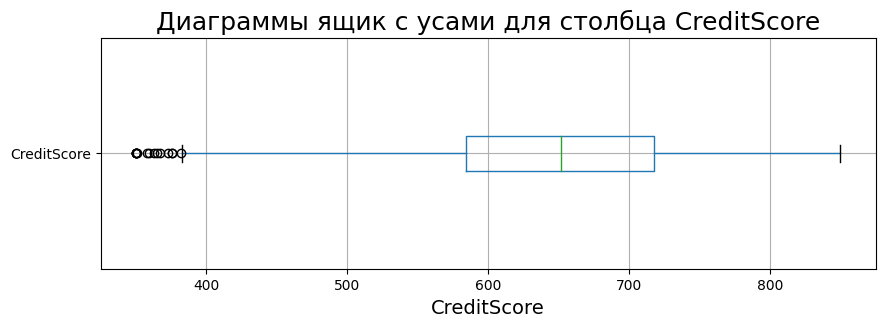

Граница левого уса -  383.0
Количество элементов расположенных ниже левого уса -  15

Граница правого уса -  919.0
Количество элементов расположенных выше правого уса -  0

!!!!!!!!!!
Промежуточный вывод:
Столбец:  CreditScore
1.1. Среднее количество CreditScore = 650.53, тогда как медианное значение равно = 652.0.
1.2. Минимальное количество CreditScore равно - 350, максимальнок количество CreditScore равно - 850
1.3. Коэффициент ассиметрии равен - -0.07, следовательно, Распределение смещено в право

****************************************************************************************************

Столбец:  Age

Описательная статистика
count    10000.000000
mean        38.921800
std         10.487806
min         18.000000
25%         32.000000
50%         37.000000
75%         44.000000
max         92.000000
Name: Age, dtype: float64


Гистограмма распределения


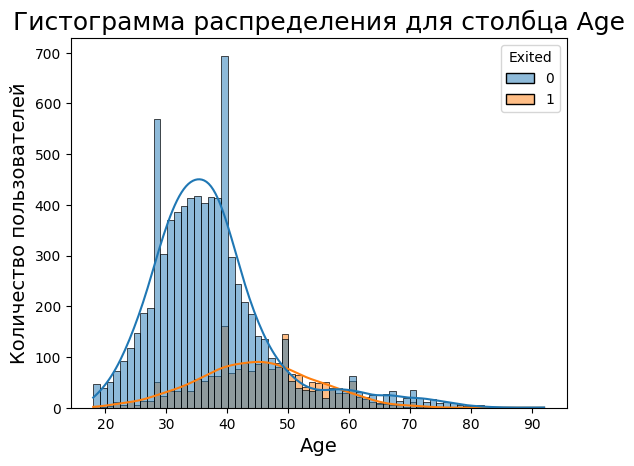

Диаграммы ящик с усами для столбца Age


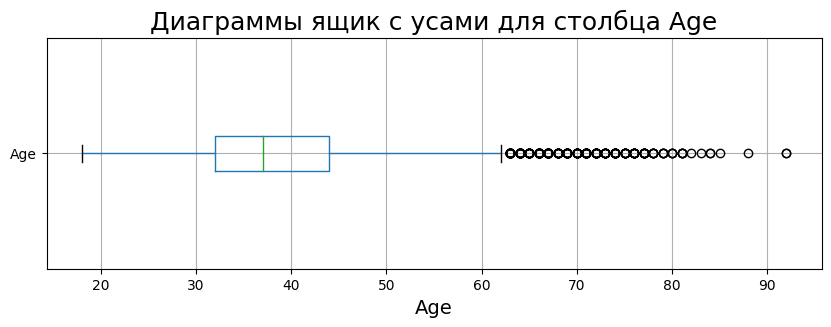

Граница левого уса -  14.0
Количество элементов расположенных ниже левого уса -  0

Граница правого уса -  62.0
Количество элементов расположенных выше правого уса -  359

!!!!!!!!!!
Промежуточный вывод:
Столбец:  Age
1.1. Среднее количество Age = 38.92, тогда как медианное значение равно = 37.0.
1.2. Минимальное количество Age равно - 18, максимальнок количество Age равно - 92
1.3. Коэффициент ассиметрии равен - 1.01, следовательно, Распределение смещено влево

****************************************************************************************************

Столбец:  Tenure

Описательная статистика
count    9091.000000
mean        4.997690
std         2.894723
min         0.000000
25%         2.000000
50%         5.000000
75%         7.000000
max        10.000000
Name: Tenure, dtype: float64


Гистограмма распределения


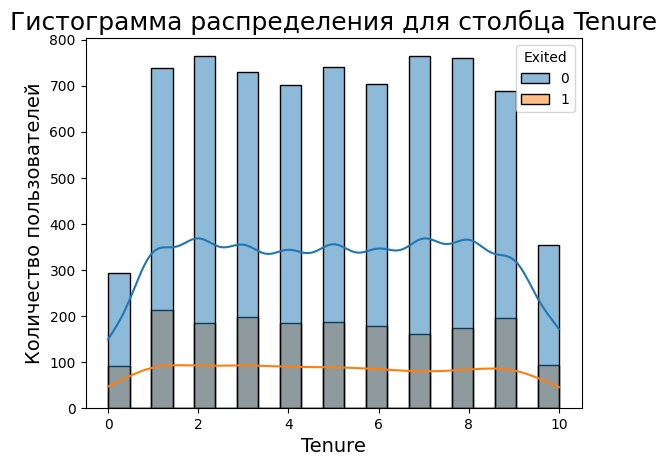

Диаграммы ящик с усами для столбца Tenure


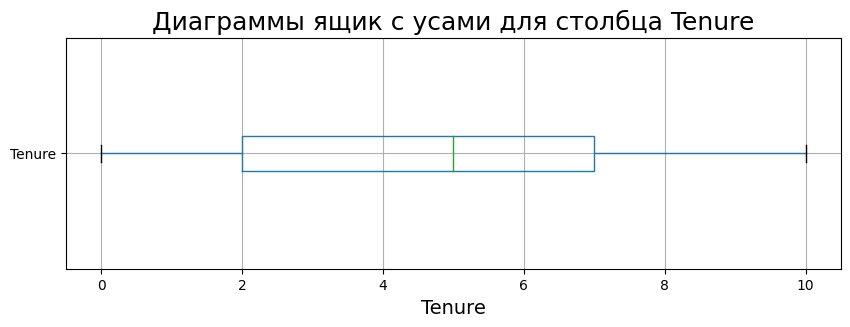

Граница левого уса -  nan
Количество элементов расположенных ниже левого уса -  0

Граница правого уса -  nan
Количество элементов расположенных выше правого уса -  0

!!!!!!!!!!
Промежуточный вывод:
Столбец:  Tenure
1.1. Среднее количество Tenure = 5.0, тогда как медианное значение равно = 5.0.
1.2. Минимальное количество Tenure равно - 0.0, максимальнок количество Tenure равно - 10.0
1.3. Коэффициент ассиметрии равен - nan, следовательно, Распределение смещено в право

****************************************************************************************************

Столбец:  Balance

Описательная статистика
count     10000.000000
mean      76485.889288
std       62397.405202
min           0.000000
25%           0.000000
50%       97198.540000
75%      127644.240000
max      250898.090000
Name: Balance, dtype: float64


Гистограмма распределения


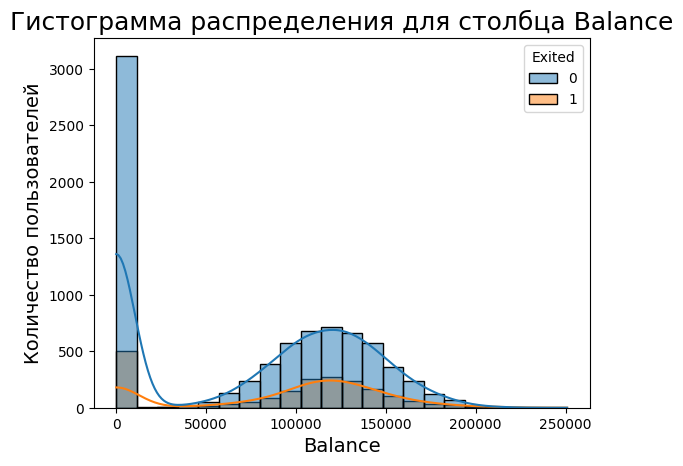

Диаграммы ящик с усами для столбца Balance


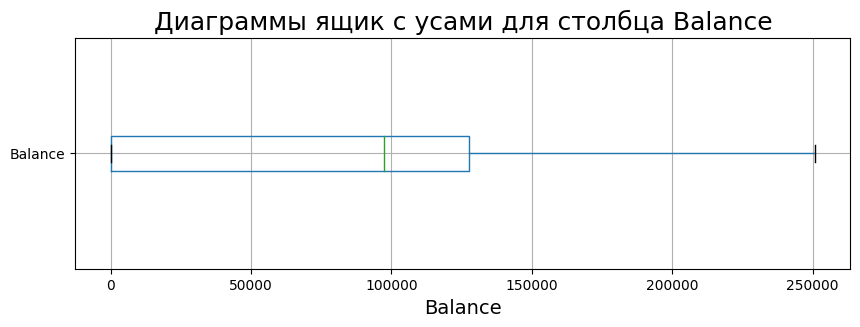

Граница левого уса -  0
Количество элементов расположенных ниже левого уса -  0

Граница правого уса -  319110.60000000003
Количество элементов расположенных выше правого уса -  0

!!!!!!!!!!
Промежуточный вывод:
Столбец:  Balance
1.1. Среднее количество Balance = 76485.89, тогда как медианное значение равно = 97198.54.
1.2. Минимальное количество Balance равно - 0.0, максимальнок количество Balance равно - 250898.09
1.3. Коэффициент ассиметрии равен - -0.14, следовательно, Распределение смещено в право

****************************************************************************************************

Столбец:  EstimatedSalary

Описательная статистика
count     10000.000000
mean     100090.239881
std       57510.492818
min          11.580000
25%       51002.110000
50%      100193.915000
75%      149388.247500
max      199992.480000
Name: EstimatedSalary, dtype: float64


Гистограмма распределения


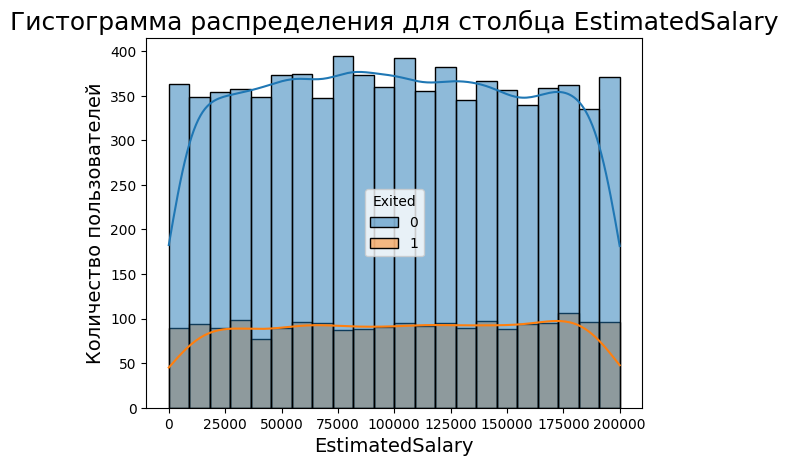

Диаграммы ящик с усами для столбца EstimatedSalary


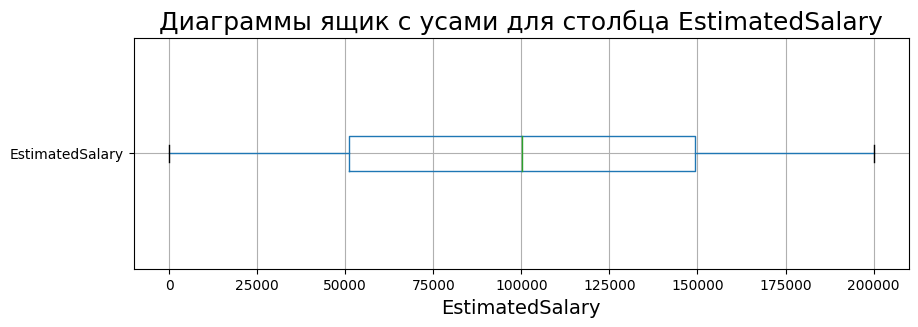

Граница левого уса -  0
Количество элементов расположенных ниже левого уса -  0

Граница правого уса -  296967.45375
Количество элементов расположенных выше правого уса -  0

!!!!!!!!!!
Промежуточный вывод:
Столбец:  EstimatedSalary
1.1. Среднее количество EstimatedSalary = 100090.24, тогда как медианное значение равно = 100193.92.
1.2. Минимальное количество EstimatedSalary равно - 11.58, максимальнок количество EstimatedSalary равно - 199992.48
1.3. Коэффициент ассиметрии равен - 0.0, следовательно, Распределение смещено в право

****************************************************************************************************



In [11]:
for column_name in data_columns_name:
    main_stat_info(data, column_name, 50, 'Exited')

**Промежуточный вывод**
- Распределения клиетов банка в столбцах CreditScore, Tenure, Balance и EstimateSalary имеют похожий вид для клиентов, которые продолжают пользоваться услугами банки, и клиетов, которые его покинули.
- Распределения данных по столбцам CreditScore, Age и Balance по виду являются нормальными
- Распределения данных по столбцам Tenure и EstimateSalary по виду являются равномерными.
- Средний возраст клиентов банка, которые продолжают пользоваться услугами банка, ниже, чем возраст клиентов, которые покинули банкт

Проверим статистическую гипотезу, что средний возраст клиентов банка, которые продолжаю толькозваться услугами банка,мменьше, чем для клиентов, которые его покинули.

**Нулевая гипотеза** - средний возраст клиентов банка, которые продолжают пользоваться услугами банка, и клиентов, которые его покинули, равны.
**Альтернативная гипотеза** - средний возраст клиентов банка, которые продолжают пользоваться услугами банка, меньше среднего возраста клиентов, которые его покинули.

In [12]:
def check_hyp_equal_mean(data1, data2, alpha, flag, name_column):
    results = st.ttest_ind(data1[name_column], data2[name_column], equal_var = False, alternative=flag)
    
    print('Параметр: ', name_column)
    print('p-value:', results.pvalue)
    
    if results.pvalue < alpha:
        print('Отвергаем нулевую гипотезу')
    else:
        print('Нет оснований отвергнуть нулевую гипотезу')
        
    print()

Разделение датасета на два: для клиентов, которые продолжают пользоваться услугами банка, и клиентов, которые его покинули.

In [13]:
data_exited = data.loc[data['Exited'] == 1]
data_not_exited = data.loc[data['Exited'] == 0]

Проверим нулевую гипотезу что средний возраст клиентов банка, которые продолжают пользоваться услугами банка, и клиентов, которые его покинули, равны.

In [14]:
check_hyp_equal_mean(data_not_exited, data_exited, 0.05, 'less', 'Age')

Параметр:  Age
p-value: 2.3563636328320523e-179
Отвергаем нулевую гипотезу



**Вывод:**  Cредний возраст клиентов банка, которые продолжают пользоваться услугами банка, меньше среднего возраста клиентов, которые его покинули.

#### 1.2.4 Категориальные данные

Уникальные значение столбца Geography

In [15]:
data['Geography'].unique()

array(['France', 'Spain', 'Germany'], dtype=object)

В датасете представлены криенты банка проживающие в трех странах: France', 'Spain', 'Germany'

Распределение данных по стране проживания

In [16]:
data.groupby('Geography')['Exited'].count().sort_values(ascending = False)

Geography
France     5014
Germany    2509
Spain      2477
Name: Exited, dtype: int64

Клиентов банка проживающих во Франции практически в 2 раза больше, чем представителей Германии и Испании.

Отобразим данные на столбчатой диаграмме

In [17]:
data_country_info = data.pivot_table(index = 'Geography', columns = 'Exited', values = 'Balance', aggfunc = 'count')
data_country_info

Exited        0    1
Geography           
France     4204  810
Germany    1695  814
Spain      2064  413

Отсортируем данные по количеству клиентов сменивших банк

In [18]:
data_country_info = data_country_info.sort_values(by = 1, ascending = False)
data_country_info

Exited        0    1
Geography           
Germany    1695  814
France     4204  810
Spain      2064  413

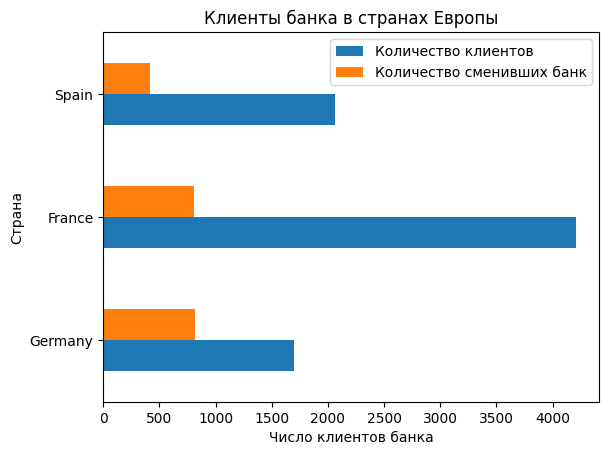

In [19]:
data_country_info.plot.barh()
plt.xlabel('Число клиентов банка')
plt.ylabel('Страна')
plt.title('Клиенты банка в странах Европы')
legend_text = ['Количество клиентов', 'Количество сменивших банк']
plt.legend(legend_text)
plt.show()

Уникальные значение столбца Gender

In [20]:
data['Gender'].unique()

array(['Female', 'Male'], dtype=object)

Распеределие пользователей по половому показателю

In [21]:
data.groupby('Gender')['Exited'].count()

Gender
Female    4543
Male      5457
Name: Exited, dtype: int64

В данных не наблюдается сильного перекоса в сторону одного из полов.

In [22]:
round(data.groupby('Gender')['Exited'].count() / len(data), 2) * 100

Gender
Female    45.0
Male      55.0
Name: Exited, dtype: float64

45 % клиентов банка - женщины. 55 % - мужчины.
Посмотрим на влияние пола на узод клиентов из банка

In [23]:
data_country_info = data.pivot_table(index = 'Gender', columns = 'Exited', values = 'Balance', aggfunc = 'count')
data_country_info

Exited     0     1
Gender            
Female  3404  1139
Male    4559   898

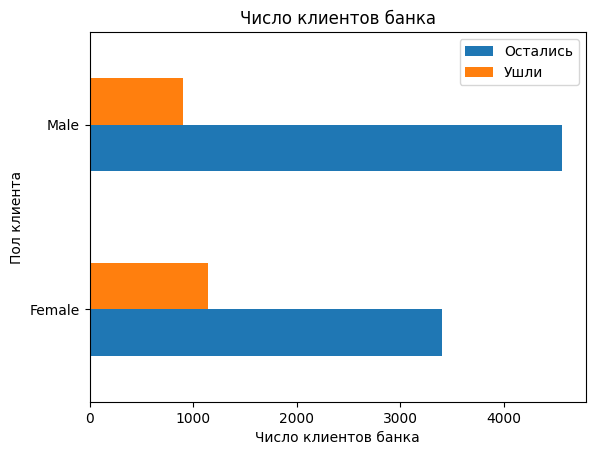

In [24]:
data_country_info.plot.barh()
plt.xlabel('Число клиентов банка')
plt.ylabel('Пол клиента')
plt.title('Число клиентов банка')
legend_text = ['Остались', 'Ушли']
plt.legend(legend_text)
plt.show()

Женщины уходят из банка чаще мужчин.

## 1.3 Дополнительная обработка данных

### 1.3.1 Заполнение нулями пронущенные значение в столбце - Tenure

In [25]:
data['Tenure'] = data['Tenure'].fillna(data['Tenure'].median())
data['Tenure'].isna().sum()

0

### 1.3.2 Кодирование категориальных признаков

*encoder = OrdinalEncoder()
data_ordinal = pd.DataFrame(encoder.fit_transform(data),
                            columns=data.columns)

*data_ordinal['Geography'].unique()

*data_ordinal.groupby('Geography')['Exited'].count().sort_values(ascending = False)

0 - Франция;
1 - Германия;
2 - Испания.

*data_ordinal['Gender'].unique()

*round(data_ordinal.groupby('Gender')['Exited'].count() / len(data), 2) * 100

0 - Женщины; 1 - Мужчины

**Промежуточный вывод** дополнительная обработка данных выполнена. Пропущенные значения в столбце Tenure заменены нулями.
Выполнено кодирование категориальных данных.

In [26]:
 # Сразу уберем не являющиеся значимыми признаки 'RowNumber', 'CustomerId', 'Surname'
data_short = data.drop(['RowNumber', 'CustomerId', 'Surname'], axis = 1)

In [27]:
data_ohe = pd.get_dummies(data_short, drop_first=True)
data_ohe.head()

CreditScore  Age  Tenure    Balance  NumOfProducts  HasCrCard  \
0          619   42     2.0       0.00              1          1   
1          608   41     1.0   83807.86              1          0   
2          502   42     8.0  159660.80              3          1   
3          699   39     1.0       0.00              2          0   
4          850   43     2.0  125510.82              1          1   

   IsActiveMember  EstimatedSalary  Exited  Geography_Germany  \
0               1        101348.88       1                  0   
1               1        112542.58       0                  0   
2               0        113931.57       1                  0   
3               0         93826.63       0                  0   
4               1         79084.10       0                  0   

   Geography_Spain  Gender_Male  
0                0            0  
1                1            0  
2                0            0  
3                0            0  
4                1            0

**Промежуточный вывод** Использую прямое кодирование категориальные признаки были преобразованы в числовые.

## 1.4 Промежуточный вывод по данным

Общая информация о датасете
- Датасет состоит из 10 000 строк и 14 столбцов;
- В датасете отсутствуют дибликаты.
- Из анализа парных диаграмм сложно выделить начилие корреляций между столбцами датасета. 
- Среднее количество CreditScore = 650.53, Минимальное количество CreditScore равно - 350, максимальнок количество CreditScore равно - 850. Распределение значений в столбце CreditScore близко к нормальному.
- Среднее количество Age = 38.92, Минимальное количество Age равно - 18, максимальнок количество Age равно - 92.
- Среднее количество Tenure = 5.0, Минимальное количество Tenure равно - 0.0, максимальнок количество Tenure равно - 10.0. Распределение близко к равномерному.
- Среднее количество Balance = 76485.89, Минимальное количество Balance равно - 0.0, максимальнок количество Balance равно - 250898.09.
- Среднее количество EstimatedSalary = 100090.24, Минимальное количество EstimatedSalary равно - 11.58, максимальнок количество EstimatedSalary равно - 199992.48.
- Распределения клиетов банка в столбцах CreditScore, Tenure, Balance и EstimateSalary имеют похожий вид для клиентов, которые продолжают пользоваться услугами банки, и клиетов, которые его покинули.
- Cредний возраст клиентов банка, которые продолжают пользоваться услугами банка, меньше среднего возраста клиентов, которые его покинули.
- Клиентов банка проживающих во Франции практически в 2 раза больше, чем представителей Германии и Испании. Однако жители Германии чаще покидают банк.
- 45 % клиентов банка - женщины. 55 % - мужчины. Женщины уходят из банка чаще мужчин.

Предобработка данных
- Пропущенные значения в столбце Tenure заменены нулями. 
- Выполнено кодирование категориальных данных.

Общий итог:
- Проведен EDA анализ 
- Данные готовы для дальнейшей работы с ними

# 2. Разделение исходных данных на выборки: обучающую, валидационную и тестовую.

## 2.1 Разделение выборки на признаки и целевые значение

In [28]:
features = data_ohe.drop(['Exited'], axis = 1)
target = data_ohe['Exited']

## 2.2 Разделение на обучающую выборку и тестовую

Разделим исходую выборку в следующих соотношениях:

обучающая выборка - 60 %;
валидационная выборка - 20 %;
тестовая выборка - 20 %.

In [29]:
X_train, X_test, y_train, y_test = train_test_split(features, target,
                                                   test_size = 0.2,
                                                   stratify = target,
                                                   random_state = 12345)

Проверка - вычислим отношение объема обучающей выборки к объему исходных данных 

In [30]:
round(len(X_train) / len(features), 2)

0.8

Отношение количества клиентов покинувщих банк к количеству пользователей оставшихся

In [31]:
print('Отношение клиентов в исходном датасете: ', round(data_ohe.groupby('Exited')['Balance'].count()[1] / data_ohe.groupby('Exited')['Balance'].count()[0], 2))

Отношение клиентов в исходном датасете:  0.26


тоже отношение в выборках

In [32]:
print('Отношение пользователей в обучающей выборке: ', round(np.bincount(y_train)[1] / np.bincount(y_train)[0],2))
print('Отношение пользователей в тестовой выборке: ', round(np.bincount(y_test)[1] / np.bincount(y_test)[0], 2))

Отношение пользователей в обучающей выборке:  0.26
Отношение пользователей в тестовой выборке:  0.26


## 2.3 Разделение на обучающую выборку и валидационную

In [33]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train,
                                                   test_size = 0.25,
                                                   stratify = y_train,
                                                   random_state = 12345)

Проверка - вычислим отношение объема обучающей выборки к объему исходных данных 

In [34]:
round(len(X_train) / len(features), 2)

0.6

тоже отношение в выборках

In [35]:
print('Отношение пользователей в обучающей выборке: ', round(np.bincount(y_train)[1] / np.bincount(y_train)[0],2))
print('Отношение пользователей в тестовой выборке: ', round(np.bincount(y_valid)[1] / np.bincount(y_valid)[0], 2))

Отношение пользователей в обучающей выборке:  0.26
Отношение пользователей в тестовой выборке:  0.26


**Промежуточный вывод**
1. Исходный датасет разделен на обучащую, валидационную и тестовую.
2. Исходный датасет разделен в соотношении 3:1:1.
3. В выборках сохраняется соотношение количества клиентов ушедших из банка к количеству оставшихся.
4. Полученные выборки будут использоваться при построении и отладке моделей машинного обучения

## 2.4 Масштабирование столбцов с количественными данными

### 2.4.1 Масштабирование столбцов с количественными данными

In [36]:
# столбцы с количественными данными
numeric = ['CreditScore', 'Tenure', 'Balance', 'EstimatedSalary', 'Age']

Масштабирование данных

In [37]:
pd.options.mode.chained_assignment = None

scaler = StandardScaler()
scaler.fit(X_train[numeric])

X_train[numeric] = scaler.transform(X_train[numeric])
X_valid[numeric] = scaler.transform(X_valid[numeric])
X_test[numeric] = scaler.transform(X_test[numeric])

### 2.4.2 Проверка выполненного масштабирования

In [38]:
print(X_train[numeric].mean())
print(X_train[numeric].std())

CreditScore        2.925068e-16
Tenure             8.289665e-17
Balance            1.207923e-16
EstimatedSalary    2.019126e-16
Age                2.581639e-16
dtype: float64
CreditScore        1.000083
Tenure             1.000083
Balance            1.000083
EstimatedSalary    1.000083
Age                1.000083
dtype: float64


In [39]:
X_train.head()

CreditScore       Age    Tenure   Balance  NumOfProducts  HasCrCard  \
5536    -0.143332  0.577533 -0.001274 -1.220573              2          1   
8530     1.632702 -0.564119 -1.092954  0.435807              1          1   
1762     1.116413 -0.468981 -1.456847  1.245822              1          1   
9090     1.643028  0.006707 -0.001274 -1.220573              1          1   
8777    -0.484083 -1.420358 -1.456847  1.421989              2          1   

      IsActiveMember  EstimatedSalary  Geography_Germany  Geography_Spain  \
5536               1         1.029613                  0                1   
8530               0         0.237986                  0                0   
1762               1        -0.686104                  0                0   
9090               0        -0.391097                  0                0   
8777               0        -1.361559                  0                1   

      Gender_Male  
5536            1  
8530            0  
1762            0  
9090            0  
8777            1

### 2.4.3 Промежуточный вывод

- Столбцы с количественными данными ['CreditScore', 'Tenure', 'Balance', 'EstimatedSalary', 'Age'] были отмасштабированы.
- В масштабированных данных среднее значение равно - нулю, Стагдартное отклонение - 1.

## 2.5 Вывод по данному разделу

- Исходный датасет разделен на обучащую, валидационную и тестовую.
- Исходный датасет разделен в соотношении 3:1:1.
- В выборках сохраняется соотношение количества клиентов ушедших из банка к количеству оставшихся.
- Полученные выборки будут использоваться при построении и отладке моделей машинного обучения.
- Столбцы с количественными данными ['CreditScore', 'Tenure', 'Balance', 'EstimatedSalary', 'Age'] были отмасштабированы.
- В масштабированных данных среднее значение равно - нулю, Стагдартное отклонение - 1.

# 3. Обучение моделей ML и исследование влияния гиперпараметров

## 3.1 Определение нижней границы качества модели с помощью DummyClassifier

In [40]:
dummy_clf = DummyClassifier(strategy = 'constant', constant = 1)
dummy_clf.fit(X_train, y_train)
f1_score(y_valid, dummy_clf.predict(X_valid))

0.3381803074366431

Минимальное значение метрики f1 = 0.338. 

## 3.2 Модель дерева решений

### 3.2.1 Оценка влияние гиперпараметра- max_depth на точность модели

In [41]:
def main_accuracy_info(X_train, y_train, X_valid, y_valid, number_of_trees):
    """
    функция вычисляет основные параметры качества модели.
    на вход подаются следующие параметры:
    - X_train, y_train: обучающая выборка;
    - X_valid, y_valid: валидационная выборка;
    - number_of_trees: максимальная глубина дерева
    
    Функция на выходе выдает dataframe c индексами - глубина слоев, а колонки - accuracy, precision, recall, f1
    
    """
    
    results = []
    for i in range(1, number_of_trees+1):
        model = DecisionTreeClassifier(max_depth = i, random_state = 12345)
        model.fit(X_train, y_train)

        predictions_valid = model.predict(X_valid)
        accuracy = accuracy_score(y_valid, predictions_valid)
        precision = precision_score(y_valid, predictions_valid)
        recall = recall_score(y_valid, predictions_valid)
        f_1 = f1_score(y_valid, predictions_valid)
        
        
        probabilities_valid = model.predict_proba(X_valid)
        probabilities_one_valid = probabilities_valid[:, 1]   
        roc_auc = roc_auc_score(y_valid, probabilities_one_valid)
        
        results.append([i, accuracy, precision, recall, f_1, roc_auc])
        
    error_info = pd.DataFrame(results,
                             columns = ['max_depth', 'accuracy','precision', 'recall','f_1','roc_auc'])
    error_info.index = error_info['max_depth']
    error_info = error_info.drop('max_depth', axis = 1)
 
    return error_info

In [42]:
   # добавил сортируску в по f1 при выводе результата.
main_error_info = main_accuracy_info(X_train, y_train, X_valid, y_valid, 20).sort_values(by = 'f_1', ascending = False)
main_error_info

C:\Users\ivanLT\anaconda3\envs\ds_practicum_env\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy  precision    recall       f_1   roc_auc
max_depth                                                   
8            0.8540   0.697595  0.498771  0.581662  0.809727
9            0.8490   0.671010  0.506143  0.577031  0.798327
11           0.8360   0.617211  0.511057  0.559140  0.760795
7            0.8555   0.750000  0.434889  0.550544  0.831058
6            0.8550   0.764706  0.415233  0.538217  0.828456
12           0.8195   0.562162  0.511057  0.535393  0.741709
10           0.8370   0.639175  0.457002  0.532951  0.778875
14           0.8095   0.534031  0.501229  0.517110  0.706380
4            0.8495   0.745370  0.395577  0.516854  0.827219
2            0.8360   0.646840  0.427518  0.514793  0.739756
15           0.8035   0.517588  0.506143  0.511801  0.700648
13           0.8110   0.539726  0.484029  0.510363  0.728920
17           0.8000   0.508685  0.503686  0.506173  0.684372
16           0.7995   0.507426  0.503686  0.505549  0.689559
20           0.7930   0.491765  0.513514  0.502404  0.690924
18           0.7920   0.489461  0.513514  0.501199  0.691952
19           0.7915   0.488095  0.503686  0.495768  0.686964
5            0.8470   0.809816  0.324324  0.463158  0.835124
3            0.8350   0.818182  0.243243  0.375000  0.804188
1            0.7965   0.000000  0.000000  0.000000  0.702042

Максимальное значение метрики f1 = 0.582 достигается при значении глубины дерева равной 8.

C:\Users\ivanLT\anaconda3\envs\ds_practicum_env\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


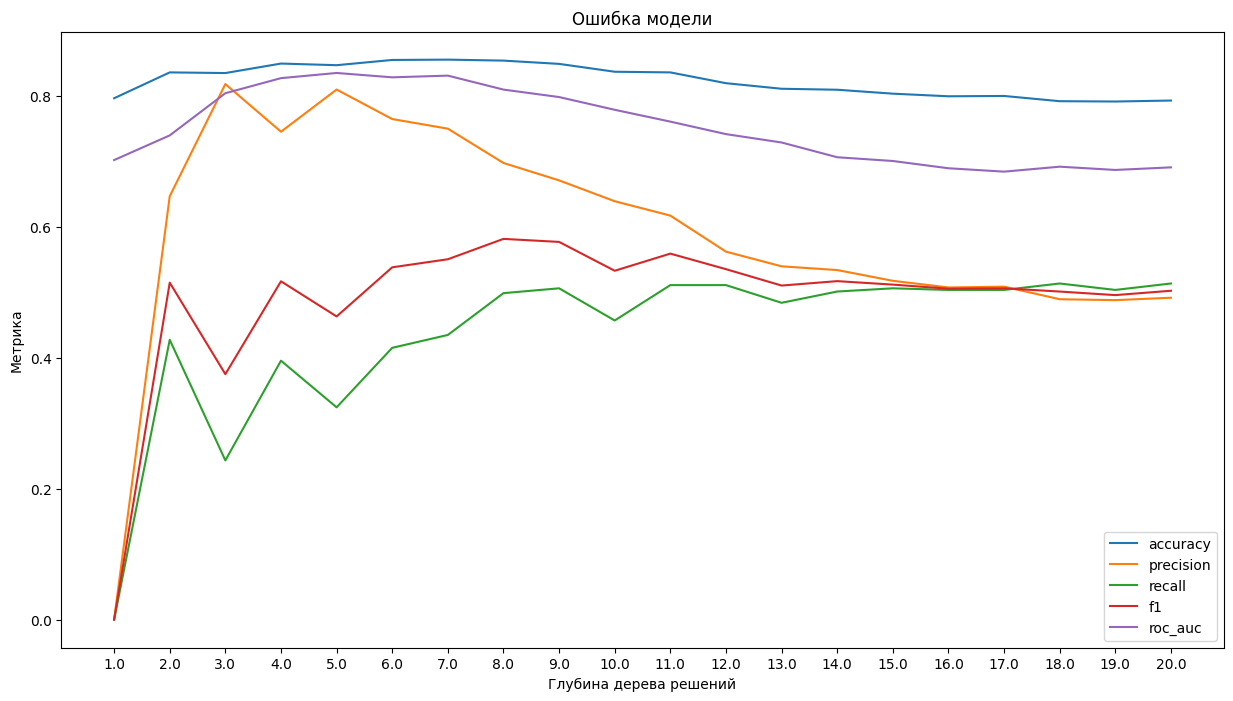

In [43]:
main_error_info = main_accuracy_info(X_train, y_train, X_valid, y_valid, 20)
plt.figure(figsize=(15,8))
plt.plot(main_error_info)
plt.xlabel('Глубина дерева решений')
x = np.linspace(1,20,20)
plt.xticks(np.linspace(1,20,20), x)
plt.ylabel('Метрика')
plt.title("Ошибка модели")
legend_info = ['accuracy','precision', 'recall','f1','roc_auc']
plt.legend(legend_info)
plt.show()

<br/>
<div class="alert alert-info">
**Вывод по графику:**
    1. Значение метрики f1 не монотонно растет при изменение глубины дерева от 3 до 8.
    2. При значениях max_depth = 8 и 9 наблюдается небольшое плато (значения f1 различаются менее чем на 0.005).
    3. При дальнейшем увеличении параметра max_depth значение метрики снижается.
    4. Величина метрик AUC = 0.835 достигает максимального значения при max_depth = 5, при последующем увеличении параметра max_depth значение метрики AUC снижается. 
    5. Значение метрики accuracy слабо засивит от исследуемого параметра, разброс метрики accuracy составляет порядка 0.05.
    6. так как метрика f1 является "средним" от метрик precision и recall, то ее значение находится между этими двумя метриками. 
</div>

Рассмотрим влияние глубины дерева на вид ROC-кривой. Ранее было получено, что наиболее оптимальным значением для параметра max_depth является 8, то метрики AUC рассмотрим диапазон [3:12].

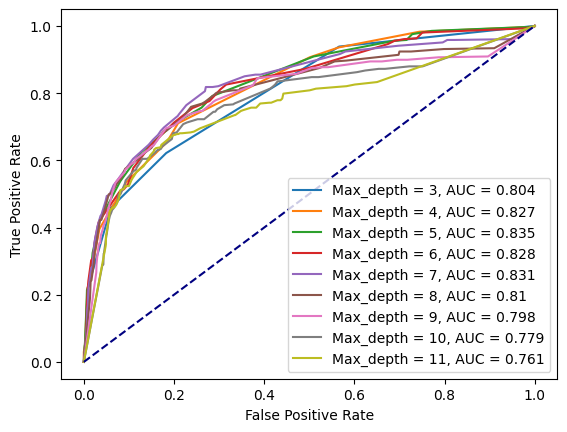

In [44]:
leg = []
for index  in range(3,12):
    
    model_DTC_max_depht = DecisionTreeClassifier(random_state = 12345, max_depth = index)
                                                           
    
    model_DTC_max_depht.fit(X_train, y_train)
    
    
    probabilities_valid = model_DTC_max_depht.predict_proba(X_valid)
    probabilities_one_valid = probabilities_valid[:, 1]
    
    
    #Calculating the FPR and TPR
    fpr, tpr, _ = roc_curve(y_valid, probabilities_one_valid)
   
    # вычисление параметра AUC
    roc_auc = round(roc_auc_score(y_valid, probabilities_one_valid), 3)
    
    note = f'Max_depth = {index}, AUC = {roc_auc}'
    leg.append(note)
    # построение графика ROC - кривой   
    plt.plot (fpr, tpr) 
    
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')    
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(leg)
plt.show() 

**Промежуточный вовод:** 
1. Зависимость метрик, оценивающих качество модели, от глубины дерева является не монотонной.
2. Доля правильных ответов (accuracy) слабо растет до значение max_depth = 5. После значения max_depth = 5 значение метрики accuracy уменьшается.
3. Точность (precision) - для данной метрики наблюдается максимум для значения max_depth = 3, после которого идет падение.
4. Метрика полнота (reсall) - максимум для данной метрики наблюдается при значении глубины дерава = 15.
5. Метрика F1, являющаяся комбинацией точности и полноты достигает своего максимального значение при значении 8. 
6. Стоит отметить, что при значении глубины дерава = 18, значения метрик precision, reall и f1 совпадают.
7. Roc_auc метрика также максимальна при значении глубины дерева равной 8.
8. В качестве предварительного оптимального значения для max_depth примем число 8, так как метрики roc_auc и F1 максимальны.

Выше проанализировано влияние только параметра max_depth. Однако необходимо посмотреть влияние других гиперпарамтеров модели дерева решений на значение метрики f1.

### 3.2.2 Подбор оптимальных гиперпараметров

In [45]:
def Hyperparam_DTC_f1(X_train, y_train, X_valid, y_valid, hyp_param_matrix, precision):
    """
    функция вычисляет основные параметры качества модели.
    на вход подаются следующие параметры:
    - X_train, y_train: обучающая выборка;
    - X_valid, y_valid: валидационная выборка;
    - hyp_param_matrix: максимальная глубина дерева
    
    Функция на выходе выдает dataframe c индексами - глубина слоев, а колонки - accuracy, precision, recall, f1
    
    """
    
    max_depth_array = hyp_param_matrix['max_depth']
    max_features_array = hyp_param_matrix['max_features']
    criterion_array = hyp_param_matrix['criterion']
    min_samples_leaf_array = hyp_param_matrix['min_samples_leaf']
    min_samples_split_array = hyp_param_matrix['min_samples_split']
    
    results = []
    
    for current_max_depth in max_depth_array:
        
        for current_max_features in max_features_array:
            
            for current_criterion in criterion_array:
                
                for current_min_samples_leaf in min_samples_leaf_array:
                    
                    for current_min_samples_split in min_samples_split_array:
                        
                        model = DecisionTreeClassifier(random_state = 12345,
                                                      max_depth = current_max_depth,
                                                      max_features = current_max_features,
                                                      criterion = current_criterion,
                                                      min_samples_leaf = current_min_samples_leaf,
                                                      min_samples_split = current_min_samples_split)
                        
                        model.fit(X_train, y_train)

                        predictions_valid = model.predict(X_valid)
                        f_1 = np.round(f1_score(y_valid, predictions_valid),precision)
                        
                        probabilities_valid = model.predict_proba(X_valid)
                        probabilities_one_valid = probabilities_valid[:, 1]
                        
                        roc_auc = np.round(roc_auc_score(y_valid, probabilities_one_valid),precision)
                        
                        results.append([current_max_depth, 
                                        current_max_features, 
                                        current_criterion,
                                        current_min_samples_leaf,
                                        current_min_samples_split,
                                        f_1, 
                                        roc_auc])
    
          
    error_info = pd.DataFrame(results,
                             columns = ['max_depth',
                                        'max_features',
                                        'criterion',
                                        'min_samples_leaf',
                                        'min_samples_split',
                                        'f_1',
                                        'roc_auc'])
  
    return error_info

In [46]:
hyp_param_matrix = {'max_depth': np.arange(5, 20, 1),
              'max_features': np.arange(2, 10, 1),
              'criterion': ['gini','entropy'],
              'min_samples_leaf': np.arange(2, 8, 1),
              'min_samples_split': np.arange(2, 8, 1),
         }

In [47]:
results_DTC = Hyperparam_DTC_f1(X_train, y_train, X_valid, y_valid, hyp_param_matrix, 7).sort_values(by = 'f_1', ascending = False)
results_DTC.head(10)

max_depth  max_features criterion  min_samples_leaf  min_samples_split  \
2769          9             8      gini                 7                  5   
2771          9             8      gini                 7                  7   
2770          9             8      gini                 7                  6   
2768          9             8      gini                 7                  4   
2767          9             8      gini                 7                  3   
2766          9             8      gini                 7                  2   
2756          9             8      gini                 5                  4   
2759          9             8      gini                 5                  7   
2757          9             8      gini                 5                  5   
2758          9             8      gini                 5                  6   

           f_1   roc_auc  
2769  0.604905  0.822186  
2771  0.604905  0.822186  
2770  0.604905  0.822186  
2768  0.604905  0.822186  
2767  0.604905  0.822186  
2766  0.604905  0.822186  
2756  0.604774  0.828025  
2759  0.604774  0.828025  
2757  0.604774  0.828025  
2758  0.604774  0.828025

In [48]:
print('Максимальное значение метрики f1 = ', results_DTC['f_1'].max())

Максимальное значение метрики f1 =  0.6049046


In [49]:
print('Гиперпараметры, обеспечивающие наибольшее значение метрик f1')
results_DTC.loc[results_DTC['f_1'] == results_DTC['f_1'].max(),].head(1)

Гиперпараметры, обеспечивающие наибольшее значение метрик f1


max_depth  max_features criterion  min_samples_leaf  min_samples_split  \
2769          9             8      gini                 7                  5   

           f_1   roc_auc  
2769  0.604905  0.822186

In [50]:
max_roc_auc = results_DTC['roc_auc'].max()
print('Максимальное значение метрики AUC = ', max_roc_auc )

Максимальное значение метрики AUC =  0.8532523


In [51]:
print('Гиперпараметры, обеспечивающие наибольшее значение метрик AUC')
results_DTC.loc[results_DTC['roc_auc'] == max_roc_auc,].head(1)

Гиперпараметры, обеспечивающие наибольшее значение метрик AUC


max_depth  max_features criterion  min_samples_leaf  min_samples_split  \
1548          7             7   entropy                 2                  2   

          f_1   roc_auc  
1548  0.57228  0.853252

**Промежуточный вывод:** 

1. Максимальное значение метрики AUC =  0.8532523.
2. Значение гиперпарамтеров, обеспечивабщих максимальное значение AUC:

	max_depth - 7,	max_features - 7, 	criterion - entropy,	min_samples_leaf - 2,	min_samples_split - 4.

**Промежуточный вывод:** 

1. На обучающей выборке после подбора гиперпараметров получено наибольшее значение метрики f1 = 0.604774.
2. Значение гиперпарамтером, обеспечивабщих максимальное значение f1:

	max_depth - 9,	max_features - 8, 	criterion - gini,	min_samples_leaf - 5,	min_samples_split - 2.
    
3. При оптимальных параметрах для f1 значение метрики AUC = 0.828025. Что не является макмимальным значением.

4. Несмотря на то, что уловие задачи выполнено - подобрана модель, обеспечивающая f1 > 0.59, в дальнейшем рассмотрим модели логистической регрессии и случайного леса.


## 3.3 Логистическая регресия

In [52]:
def Hyperparam_LR_f1(X_train, y_train, X_valid, y_valid, hyp_param_matrix, precision):
    """
    функция вычисляет основные параметры качества модели.
    на вход подаются следующие параметры:
    - X_train, y_train: обучающая выборка;
    - X_valid, y_valid: валидационная выборка;
    - hyp_param_matrix: максимальная глубина дерева
    
    Функция на выходе выдает dataframe c индексами - глубина слоев, а колонки - accuracy, precision, recall, f1
    
    """
    
    penalty_array = hyp_param_matrix['penalty']
    tol_array = hyp_param_matrix['tol']
    max_iter_array = hyp_param_matrix['max_iter']
    
    
    results = []
    
    for current_penalty in penalty_array:
        
        for current_tol in tol_array:
            
            for current_max_iter in max_iter_array:
                
               
                        
                model = LogisticRegression(random_state = 12345, 
                                           solver = 'lbfgs',
                                           penalty = current_penalty,
                                           tol = current_tol,
                                           max_iter = current_max_iter)
                        
                model.fit(X_train, y_train)

                predictions_valid = model.predict(X_valid)
                f_1 = np.round(f1_score(y_valid, predictions_valid),precision)
                        
                probabilities_valid = model.predict_proba(X_valid)
                probabilities_one_valid = probabilities_valid[:, 1]
                        
                roc_auc = np.round(roc_auc_score(y_valid, probabilities_one_valid),precision)
                        
                results.append([current_penalty,
                                current_tol,
                                current_max_iter,
                                f_1, 
                                roc_auc])
    
          
    error_info = pd.DataFrame(results,
                             columns = ['penalty',
                                        'tol',
                                        'max_iter',
                                        'f_1',
                                        'roc_auc'])
  
    return error_info

In [53]:
LGR_space={'penalty':['l2'],
        'tol':[1e-4, 1e-5, 1e-6, 1e-7],
        'max_iter': np.arange(100, 100000, 500) 
         }

In [54]:
results_LR = Hyperparam_LR_f1(X_train, y_train, X_valid, y_valid, LGR_space, 7).sort_values(by = 'f_1', ascending = False)
results_LR.head(10)

penalty       tol  max_iter       f_1   roc_auc
0        l2  0.000100       100  0.321495  0.787566
537      l2  0.000001     68600  0.321495  0.787566
527      l2  0.000001     63600  0.321495  0.787566
528      l2  0.000001     64100  0.321495  0.787566
529      l2  0.000001     64600  0.321495  0.787566
530      l2  0.000001     65100  0.321495  0.787566
531      l2  0.000001     65600  0.321495  0.787566
532      l2  0.000001     66100  0.321495  0.787566
533      l2  0.000001     66600  0.321495  0.787566
534      l2  0.000001     67100  0.321495  0.787566

In [55]:
print('Максимальное значение метрики f1 = ', results_LR['f_1'].max())

Максимальное значение метрики f1 =  0.3214953


In [56]:
print('Гиперпараметры, обеспечивающие наибольшее значение метрик f1')
results_LR.loc[results_LR['f_1'] == results_LR['f_1'].max(),].head(1)

Гиперпараметры, обеспечивающие наибольшее значение метрик f1


penalty     tol  max_iter       f_1   roc_auc
0      l2  0.0001       100  0.321495  0.787566

In [57]:
max_roc_auc = results_LR['roc_auc'].max()
print('Максимальное значение метрики AUC = ', max_roc_auc )

Максимальное значение метрики AUC =  0.7875657


In [58]:
print('Гиперпараметры, обеспечивающие наибольшее значение метрик AUC')
results_LR.loc[results_LR['roc_auc'] == max_roc_auc,].head(1)

Гиперпараметры, обеспечивающие наибольшее значение метрик AUC


penalty     tol  max_iter       f_1   roc_auc
0      l2  0.0001       100  0.321495  0.787566

1. Максимальное значение метрики AUC =  0.787566.
2. Значение гиперпарамтеров, обеспечивабщих максимальное значение AUC:
penalty = l2,
tol - 0.0001,
max_iter = 100

**Промежуточный вывод:** 

1. На обучающей выборке после подбора гиперпараметров получено наибольшее значение метрики f1 = 0.3214953.
2. Значение гиперпарамтером, обеспечивабщих максимальное значение f1:

	penalty = l2, tol - 0.0001, max_iter = 100
    
3. Модель логистической регресии дала значение метрики f1 практичеcки в 2 раза ниже, чем модель дерева решений.


## 3.4 Модель случайного леса

### 3.4.1 Подбор оптимальных гиперпараметров с помощью перебора значений в цикле

In [59]:
def Hyperparam_RFC_f1(X_train, y_train, X_valid, y_valid, hyp_param_matrix, precision):
    """
    функция вычисляет основные параметры качества модели.
    на вход подаются следующие параметры:
    - X_train, y_train: обучающая выборка;
    - X_valid, y_valid: валидационная выборка;
    - hyp_param_matrix: максимальная глубина дерева
    
    Функция на выходе выдает dataframe c индексами - глубина слоев, а колонки - accuracy, precision, recall, f1
    
    """
    
    max_depth_array = hyp_param_matrix['max_depth']
    max_features_array = hyp_param_matrix['max_features']
    criterion_array = hyp_param_matrix['criterion']
    min_samples_leaf_array = hyp_param_matrix['min_samples_leaf']
    min_samples_split_array = hyp_param_matrix['min_samples_split']
    n_estimator_array = hyp_param_matrix['n_estimators']
    
    results = []
    
    for current_max_depth in max_depth_array:
        
        for current_max_features in max_features_array:
            
            for current_criterion in criterion_array:
                
                for current_min_samples_leaf in min_samples_leaf_array:
                    
                    for current_min_samples_split in min_samples_split_array:
                        
                        for current_n_estimators in n_estimator_array:
                            
                            
                        
                            model = RandomForestClassifier(random_state = 12345,
                                                          max_depth = current_max_depth,
                                                          max_features = current_max_features,
                                                          criterion = current_criterion,
                                                          min_samples_leaf = current_min_samples_leaf,
                                                          min_samples_split = current_min_samples_split,
                                                          n_estimators = current_n_estimators)
                        
                            model.fit(X_train, y_train)

                            predictions_valid = model.predict(X_valid)
                            f_1 = np.round(f1_score(y_valid, predictions_valid),precision)
                        
                            probabilities_valid = model.predict_proba(X_valid)
                            probabilities_one_valid = probabilities_valid[:, 1]
                            
                            roc_auc = np.round(roc_auc_score(y_valid, probabilities_one_valid),precision)
                        
                            results.append([current_max_depth, 
                                        current_max_features, 
                                        current_criterion,
                                        current_min_samples_leaf,
                                        current_min_samples_split,
                                        current_n_estimators,
                                        f_1, 
                                        roc_auc])
    
          
    error_info = pd.DataFrame(results,
                             columns = ['max_depth',
                                        'max_features',
                                        'criterion',
                                        'min_samples_leaf',
                                        'min_samples_split',
                                        'n_estimators',
                                        'f_1',
                                        'roc_auc'])
  
    return error_info

In [60]:
rf_space={'max_depth': np.arange(4, 14, 2),
              'n_estimators': np.arange(10, 60, 10),
              'max_features': np.arange(2, 5, 1),
              'criterion': ['gini','entropy'],
              'min_samples_leaf': np.arange(2, 5, 1),
              'min_samples_split': np.arange(2, 5, 1)
         }

In [61]:
results_RFC = Hyperparam_RFC_f1(X_train, y_train, X_valid, y_valid, rf_space, 7).sort_values(by = 'f_1', ascending = False)
results_RFC.head(10)

max_depth  max_features criterion  min_samples_leaf  min_samples_split  \
1309         12             4   entropy                 2                  2   
1314         12             4   entropy                 2                  3   
1319         12             4   entropy                 2                  4   
1307         12             4   entropy                 2                  2   
1312         12             4   entropy                 2                  3   
1317         12             4   entropy                 2                  4   
1308         12             4   entropy                 2                  2   
1313         12             4   entropy                 2                  3   
1318         12             4   entropy                 2                  4   
917          10             3      gini                 3                  2   

      n_estimators       f_1   roc_auc  
1309            50  0.581649  0.860657  
1314            50  0.581649  0.860657  
1319            50  0.581649  0.860657  
1307            30  0.575000  0.854279  
1312            30  0.575000  0.854279  
1317            30  0.575000  0.854279  
1308            40  0.574568  0.858291  
1313            40  0.574568  0.858291  
1318            40  0.574568  0.858291  
917             30  0.571429  0.866551

In [62]:
print('Максимальное значение метрики f1 = ', results_RFC['f_1'].max())

Максимальное значение метрики f1 =  0.5816485


In [63]:
print('Гиперпараметры, обеспечивающие наибольшее значение метрик f1')
results_RFC.loc[results_RFC['f_1'] == results_RFC['f_1'].max(),].head(1)

Гиперпараметры, обеспечивающие наибольшее значение метрик f1


max_depth  max_features criterion  min_samples_leaf  min_samples_split  \
1309         12             4   entropy                 2                  2   

      n_estimators       f_1   roc_auc  
1309            50  0.581649  0.860657

In [64]:
max_roc_auc = results_RFC['roc_auc'].max()
print('Максимальное значение метрики AUC = ', max_roc_auc )

Максимальное значение метрики AUC =  0.872249


In [65]:
print('Гиперпараметры, обеспечивающие наибольшее значение метрик AUC')
results_RFC.loc[results_RFC['roc_auc'] == max_roc_auc,].head(1)

Гиперпараметры, обеспечивающие наибольшее значение метрик AUC


max_depth  max_features criterion  min_samples_leaf  min_samples_split  \
519          6             4   entropy                 3                  3   

     n_estimators       f_1   roc_auc  
519            50  0.501707  0.872249

**Промежуточный вывод:** 

1. На обучающей выборке после подбора гиперпараметров получено наибольшее значение метрики f1 = 0.5816485.
2. Значение гиперпарамтером, обеспечивабщих максимальное значение f1:

	max_depth - 12,	max_features - 4, 	criterion - entropy,	min_samples_leaf - 3,	min_samples_split - 3, n_estimators = 50.
    
3. При оптимальных параметрах для f1 значение метрики AUC = 0.860657. Что не является макмимальным значением.


4. Значением f1, полученное моделью случайного леса ниже, чем установлено заданием и ниже значения, полученного для дерева решений.

5. Необходимо провести балансировку классов.


## 3.5 Промежуточный вывод

1. Проанализированы три классификатора: Дерево решений (DecisionTreeClassifier), метод случайного леса (RandomForestClassifier) и Логистическая регрессия (LogisticRegression)
2. Для каждой модели качество подобранных гиперпараметров было проверено на валибационной выборке, показавшей что выбранные гиперпараметры адекватно работают на выборке отличающейся от обучающей.
3. Для рассмотренные модели показали следующие значения целевого показателя на валидационной выборке:
-  **Дерево решений (DecisionTreeClassifier)** - 0.604774;
-  **Логистическая регрессия (LogisticRegression)** - 0.3214953;
-  **Метод случайного леса (RandomForestClassifier)** -  0.5816485.
4. Значением f1, полученное моделью случайного леса ниже, чем установлено заданием и ниже значения, полученного для дерева решений.
5. В исходной выборке существует значительное преобладание класса "0", в соотношении 4:1. Для увеличения качества модели выровняем выборки.

# 4. Выравнивание выборок

## 4.1 Выравнивание признаков

Функция для увеличения объема (upsampling) положительного класса

In [66]:
def upsample(features, target, repeat):
    """
    Функция для увеличения объема выборки методом upsampling
    
    Входные параметры:
    - features - матрица с признаками;
    - target - признаки
    - количество повтторений.
    
    На выходе функция выбает два массива: матрицу с признаками и массив с целевыми данными, в которых объем "положительного" 
    класса увеличен.
    """
    
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

In [67]:
X_upsampled, y_upsampled = upsample(X_train, y_train, 4)

Проверим объемы полученных выборок

In [68]:
print(len(y_upsampled[y_upsampled == 0]))
print(len(y_upsampled[y_upsampled == 1]))

4777
4892


**Промежуточный вывод** С помощью метода upsampling удалось выровнить классы в обучающей выборке. Соотношение "положительного" и "отрицательного" классов близко к единице. Задача выравнимания классов выполнена.

# 5. Обучение и проверка модели на "расширенной" выборке. Модель дерева решений

На предыдуших этапах работы модель дерева решений показала значения целевого показателя 0.60, что не сильно отличается от модели случайного леса с наилучшим результатом - 0.588. 
Однако модель случайного леса является очень ресурсо- и времязатратной. 
Для дальнейшей работы выберем модель дерева решений, так как целевой показатель получился на несбалансированной выборке даже выше, чем для модели случайного леса.

### 5.1 Подбор оптимальных гиперпараметров методом случайного поиска

In [69]:
X_upsampled, y_upsampled = upsample(X_train, y_train, 4)

In [70]:
results_DTC_upsamp = Hyperparam_DTC_f1(X_upsampled, y_upsampled, X_valid, y_valid, hyp_param_matrix, 7).sort_values(by = 'f_1', ascending = False)
results_DTC_upsamp.head(10)

max_depth  max_features criterion  min_samples_leaf  min_samples_split  \
2531          9             5      gini                 3                  7   
2031          8             6      gini                 4                  5   
2028          8             6      gini                 4                  2   
2030          8             6      gini                 4                  4   
2032          8             6      gini                 4                  6   
2033          8             6      gini                 4                  7   
2029          8             6      gini                 4                  3   
1985          8             5   entropy                 2                  7   
1984          8             5   entropy                 2                  6   
1548          7             7   entropy                 2                  2   

           f_1   roc_auc  
2531  0.611863  0.816471  
2031  0.602339  0.838484  
2028  0.602339  0.838484  
2030  0.602339  0.838484  
2032  0.602339  0.838484  
2033  0.602339  0.838484  
2029  0.602339  0.838484  
1985  0.596789  0.833267  
1984  0.596789  0.833267  
1548  0.596296  0.856151

In [71]:
print('Максимальное значение метрики f1 = ', results_DTC_upsamp['f_1'].max())

Максимальное значение метрики f1 =  0.6118626


In [72]:
print('Гиперпараметры, обеспечивающие наибольшее значение метрик f1')
results_DTC_upsamp.loc[results_DTC_upsamp['f_1'] == results_DTC_upsamp['f_1'].max(),].head(1)

Гиперпараметры, обеспечивающие наибольшее значение метрик f1


max_depth  max_features criterion  min_samples_leaf  min_samples_split  \
2531          9             5      gini                 3                  7   

           f_1   roc_auc  
2531  0.611863  0.816471

In [73]:
max_roc_auc = results_DTC_upsamp['roc_auc'].max()
print('Максимальное значение метрики AUC = ', max_roc_auc )

Максимальное значение метрики AUC =  0.8561512


In [74]:
print('Гиперпараметры, обеспечивающие наибольшее значение метрик AUC')
results_DTC_upsamp.loc[results_DTC_upsamp['roc_auc'] == max_roc_auc,].head(1)

Гиперпараметры, обеспечивающие наибольшее значение метрик AUC


max_depth  max_features criterion  min_samples_leaf  min_samples_split  \
1548          7             7   entropy                 2                  2   

           f_1   roc_auc  
1548  0.596296  0.856151

**Промежуточный вывод:** 
1. Увеличением количества повторений в методе upsamling не позволило  повысить значение метрики f1.
2. Максимальное значение метрики AUC = 0.8561512 для модели обученной на сбалансированной выборке. Полученное значение несколько первышает, ранее полученное для данной модели, обученной на несбалансированной выборке -   0.8532523.

In [75]:
f_1_score = []

Model_param_matrix = []

for N_upsamp in range(1, 10):
    
    X_upsampled, y_upsampled = upsample(X_train, y_train, N_upsamp)
    
    results_DTC_upsamp = Hyperparam_DTC_f1(X_upsampled, y_upsampled, X_valid, y_valid, hyp_param_matrix, 10)
    
    f1_max = results_DTC_upsamp['f_1'].max()
    
    model_param = results_DTC_upsamp.loc[results_DTC_upsamp['f_1'] == f1_max].iloc[0]
    #model_param = model_param.values[0,]
    Model_param_matrix.append(model_param)

In [76]:
Model_param_matrix_df = pd.DataFrame(Model_param_matrix, 
                                    columns = results_DTC_upsamp.columns,
                                    index = np.arange(1,10,1))
Model_param_matrix_df.sort_values(by = 'f_1', ascending = False)

max_depth  max_features criterion  min_samples_leaf  min_samples_split  \
3          7             7   entropy                 2                  2   
2          7             4   entropy                 5                  2   
4          9             5      gini                 3                  7   
1          9             8      gini                 7                  2   
5          9             6      gini                 5                  2   
6          7             7   entropy                 4                  2   
7          8             9   entropy                 4                  2   
9         19             7      gini                 6                  2   
8          8             5   entropy                 7                  2   

        f_1   roc_auc  
3  0.630480  0.856151  
2  0.615776  0.836646  
4  0.611863  0.816471  
1  0.604905  0.822186  
5  0.586815  0.832105  
6  0.580139  0.852122  
7  0.561462  0.834480  
9  0.560621  0.761510  
8  0.555823  0.832734

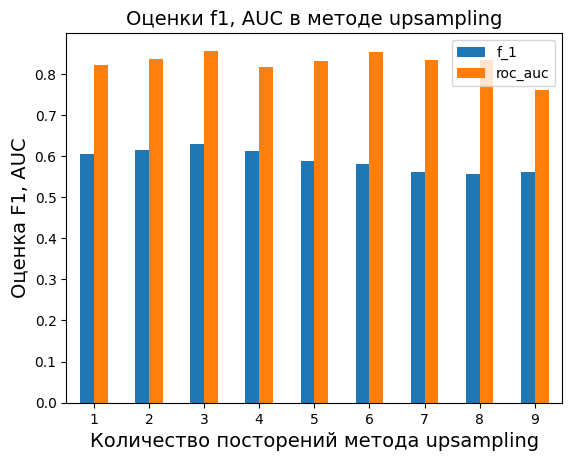

In [77]:
Model_param_matrix_df[['f_1','roc_auc']].plot.bar()
plt.xlabel('Количество посторений метода upsampling', fontsize = 14)
plt.ylabel('Оценка F1, AUC', fontsize = 14)
plt.xticks(rotation=0)
plt.title('Оценки f1, AUC в методе upsampling', fontsize = 14)
plt.show()

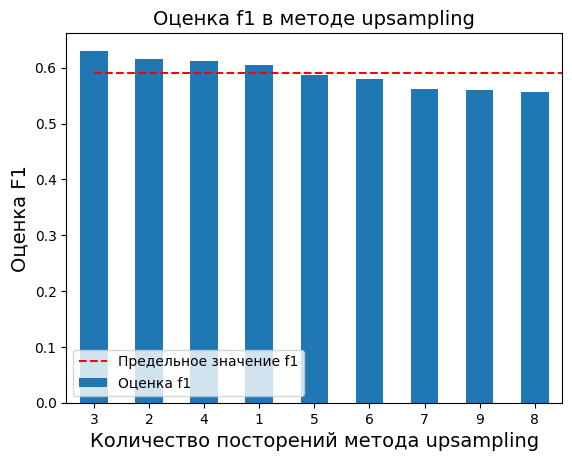

In [78]:
#Model_param_matrix_df[['f_1','roc_auc']].sort_values(ascending = False).plot.bar(rot = 90)
Model_param_matrix_df['f_1'].sort_values(ascending = False).plot.bar()
plt.xlabel('Количество посторений метода upsampling', fontsize = 14)
plt.ylabel('Оценка F1', fontsize = 14)
plt.xticks(rotation=0)
f1_limit = np.linspace(0.59, 0.59, 12)
plt.plot(f1_limit, '--', color = 'red')
plt.title('Оценка f1 в методе upsampling', fontsize = 14)
notes = ['Предельное значение f1', 'Оценка f1']
plt.legend(notes)
plt.show()

**Промежуточный вывод**
1. В зависимости от количества повторений в методе upsampling мера f1 может как возрастать, так и уменьшаться.
2. Оптимальным каличеством повторений, соотверствующих максимальным оценкам f1 и AUC, является значение - 3. f1 = 0.630480
3. Исходный дисбаланс классов 4:1. При количестве посторений от 2 и 3 величина меры f1 возрастает относительно несбалансированной выборке. При равенстве классов N=4, мера F1 все еще выше требуемого значение 0.59.
4. Дальнейшее увелечение объема "положительного" класса приводит к снижению значения меры f1.
5. Максимальное значение метрики AUC = 0.856151 достигается при N=3, также как и для f1.
6. Характер зависимости метрики AUC от N повторяет характер зависимости для f1 при N лежащих в диапазоне от 1 до 4. При дальнейшем увеличении N характер поведения метрик разнится.

# 6. Обучение и проверка модели на "расширенной" выборке. Модель случайного леса

In [79]:
X_upsampled, y_upsampled = upsample(X_train, y_train, 3)

In [80]:
results_RFC_upsamp = Hyperparam_RFC_f1(X_upsampled, y_upsampled, X_valid, y_valid, rf_space, 7).sort_values(by = 'f_1', ascending = False)
results_RFC_upsamp.head(10)

max_depth  max_features criterion  min_samples_leaf  min_samples_split  \
313          6             2      gini                 4                  4   
303          6             2      gini                 4                  2   
308          6             2      gini                 4                  3   
852         10             2      gini                 4                  4   
842         10             2      gini                 4                  2   
847         10             2      gini                 4                  3   
274          6             2      gini                 2                  2   
279          6             2      gini                 2                  3   
284          6             2      gini                 2                  4   
307          6             2      gini                 4                  3   

     n_estimators       f_1   roc_auc  
313            40  0.655621  0.868525  
303            40  0.655621  0.868525  
308            40  0.655621  0.868525  
852            30  0.653938  0.869379  
842            30  0.653938  0.869379  
847            30  0.653938  0.869379  
274            50  0.652278  0.866870  
279            50  0.652278  0.866870  
284            50  0.652278  0.866870  
307            30  0.647821  0.865874

In [81]:
print('Максимальное значение метрики f1 = ', results_RFC_upsamp['f_1'].max())

Максимальное значение метрики f1 =  0.6556213


In [82]:
print('Гиперпараметры, обеспечивающие наибольшее значение метрик f1')
results_RFC_upsamp.loc[results_RFC_upsamp['f_1'] == results_RFC_upsamp['f_1'].max(),].head(1)

Гиперпараметры, обеспечивающие наибольшее значение метрик f1


max_depth  max_features criterion  min_samples_leaf  min_samples_split  \
313          6             2      gini                 4                  4   

     n_estimators       f_1   roc_auc  
313            40  0.655621  0.868525

In [83]:
max_roc_auc = results_RFC_upsamp['roc_auc'].max()
print('Максимальное значение метрики AUC = ', max_roc_auc )

Максимальное значение метрики AUC =  0.8758635


In [84]:
print('Гиперпараметры, обеспечивающие наибольшее значение метрик AUC')
results_RFC_upsamp.loc[results_RFC_upsamp['roc_auc'] == max_roc_auc,].head(1)

Гиперпараметры, обеспечивающие наибольшее значение метрик AUC


max_depth  max_features criterion  min_samples_leaf  min_samples_split  \
769          8             4   entropy                 2                  2   

     n_estimators       f_1   roc_auc  
769            50  0.630872  0.875864

**Промежуточный вывод:** 
1. Увеличением количества повторений в методе upsamling позволило  повысить значение метрики f1 до значения - 0.655621.
2. Максимальное значение метрики AUC = 0.875864 для модели обученной на сбалансированной выборке.

In [85]:
Model_param_matrix_RFC = []

for N_upsamp in range(1, 4):
    
    X_upsampled, y_upsampled = upsample(X_train, y_train, N_upsamp)
    
    results_RFC_upsamp = Hyperparam_RFC_f1(X_upsampled, y_upsampled, X_valid, y_valid, rf_space, 10)
    
    f1_max = results_RFC_upsamp['f_1'].max()
    
    model_param = results_RFC_upsamp.loc[results_RFC_upsamp['f_1'] == f1_max].iloc[0]
    #model_param = model_param.values[0,]
    Model_param_matrix_RFC.append(model_param)

In [86]:
Model_param_matrix_RFC_df = pd.DataFrame(Model_param_matrix_RFC, 
                                    columns = results_RFC_upsamp.columns,
                                    index = np.arange(1,4,1))
Model_param_matrix_RFC_df.sort_values(by = 'f_1', ascending = False)

max_depth  max_features criterion  min_samples_leaf  min_samples_split  \
3          6             2      gini                 4                  2   
2         10             3   entropy                 4                  2   
1         12             4      gini                 4                  2   

   n_estimators       f_1   roc_auc  
3            40  0.655621  0.868525  
2            40  0.638356  0.873093  
1            40  0.582160  0.866580

In [87]:
Model_param_matrix_RFC_df[['f_1','roc_auc']].plot.bar()
plt.xlabel('Количество посторений метода upsampling', fontsize = 14)
plt.ylabel('Оценка F1, AUC', fontsize = 14)
plt.xticks(rotation=0)
plt.title('Оценки f1, AUC в методе upsampling', fontsize = 14)
plt.show()

In [88]:
#Model_param_matrix_df[['f_1','roc_auc']].sort_values(ascending = False).plot.bar(rot = 90)
Model_param_matrix_RFC_df['f_1'].sort_values(ascending = False).plot.bar()
plt.xlabel('Количество посторений метода upsampling', fontsize = 14)
plt.ylabel('Оценка F1', fontsize = 14)
plt.xticks(rotation=0)
f1_limit = np.linspace(0.59, 0.59, 12)
plt.plot(f1_limit, '--', color = 'red')
plt.title('Оценка f1 в методе upsampling', fontsize = 14)
notes = ['Предельное значение f1', 'Оценка f1']
plt.legend(notes)
plt.show()

**Промежуточный вывод**
1. Метод upsampling позволил увеличить значение метрики f1. 
2. Оптимальным количеством повторений, соотверствующих максимальной оценке f1, является значение - 3. f1 = 0.655621.
3. Максимальное значение метрики AUC = 0.873093 достигается при N=2.
4. При оптимальном значении количества повторений метода upsampling с точки зрения метрики f1 - N=3, значение AUC почти на  0.01 ниже оптимального значения.  
6. Модель случайного леса показала наилучшие результаты как для метрики f1, так и для метрики AUC.

# 6. Проверка качества модели на тестовой выборке

In [93]:
X_upsampled, y_upsampled = upsample(X_train, y_train, 4)

In [94]:
model = RandomForestClassifier(random_state = 12345,
                                max_depth = Model_param_matrix_RFC_df.loc[3, 'max_depth'],
                                max_features = Model_param_matrix_RFC_df.loc[3, 'max_features'],
                                criterion = Model_param_matrix_RFC_df.loc[3, 'criterion'],
                                min_samples_leaf = Model_param_matrix_RFC_df.loc[3, 'min_samples_leaf'],
                                min_samples_split = Model_param_matrix_RFC_df.loc[3, 'min_samples_split'],
                                n_estimators = Model_param_matrix_RFC_df.loc[3, 'n_estimators'])
                        
model.fit(X_upsampled, y_upsampled)

predictions_valid = model.predict(X_test)
f_1 = np.round(f1_score(y_test, predictions_valid),10)


probabilities_valid = model.predict_proba(X_test)
probabilities_one_valid = probabilities_valid[:, 1]
roc_auc = np.round(roc_auc_score(y_test, probabilities_one_valid),10)
print('Значение метрики f1 = ', f_1)
print('Значение метрики AUC = ', roc_auc)

Значение метрики f1 =  0.591954023
Значение метрики AUC =  0.8557016184


**Промежуточный вывод**: На тестовой модели значение метрики f1 = 0.591954023. Значение метрик AUC = 0.8557016184
Условия задания выполнено.

# Вывод по работе

1. **Общая информация о датасете**
- Датасет состоит из 10 000 строк и 14 столбцов;
- В датасете отсутствуют дибликаты.
- Из анализа парных диаграмм сложно выделить начилие корреляций между столбцами датасета. 
- Среднее количество CreditScore = 650.53, Минимальное количество CreditScore равно - 350, максимальнок количество CreditScore равно - 850. Распределение значений в столбце CreditScore близко к нормальному.
- Среднее количество Age = 38.92, Минимальное количество Age равно - 18, максимальнок количество Age равно - 92.
- Среднее количество Tenure = 5.0, Минимальное количество Tenure равно - 0.0, максимальнок количество Tenure равно - 10.0. Распределение близко к равномерному.
- Среднее количество Balance = 76485.89, Минимальное количество Balance равно - 0.0, максимальнок количество Balance равно - 250898.09.
- Среднее количество EstimatedSalary = 100090.24, Минимальное количество EstimatedSalary равно - 11.58, максимальнок количество EstimatedSalary равно - 199992.48.
- Распределения клиетов банка в столбцах CreditScore, Tenure, Balance и EstimateSalary имеют похожий вид для клиентов, которые продолжают пользоваться услугами банки, и клиетов, которые его покинули.
- Cредний возраст клиентов банка, которые продолжают пользоваться услугами банка, меньше среднего возраста клиентов, которые его покинули.
- Клиентов банка проживающих во Франции практически в 2 раза больше, чем представителей Германии и Испании. Однако жители Германии чаще покидают банк.
- 45 % клиентов банка - женщины. 55 % - мужчины. Женщины уходят из банка чаще мужчин.

Предобработка данных
- Пропущенные значения в столбце Tenure заменены нулями. 
- Выполнено кодирование категориальных данных.

2. **Разделение данных на выборки**
- Исходный датасет разделен на обучащую, валидационную и тестовую в соотношении 3:1:1.
- В выборках сохраняется соотношение количества клиентов ушедших из банка к количеству оставшихся.
- Полученные выборки использованы при построении и отладке моделей машинного обучения.
- Столбцы с количественными данными ['CreditScore', 'Tenure', 'Balance', 'EstimatedSalary', 'Age'] были отмасштабированы.
- В масштабированных данных среднее значение равно - нулю, Стандартное отклонение - 1.
3. **Анализ поведения различных классификаторов**

    Проанализированы три классификатора: Дерево решений (DecisionTreeClassifier), метод случайного леса (RandomForestClassifier) и Логистическая регрессия (LogisticRegression)
    Для каждой модели качество подобранных гиперпараметров было проверено на валибационной выборке, показавшей что выбранные гиперпараметры адекватно работают на выборке отличающейся от обучающей.
    Для рассмотренные модели показали следующие значения целевого показателя на валидационной выборке:
-  **Дерево решений (DecisionTreeClassifier)** - 0.604774;
-  **Логистическая регрессия (LogisticRegression)** - 0.3214953;
-  **Метод случайного леса (RandomForestClassifier)** -  0.5816485.
    Значением f1, полученное моделью случайного леса ниже, чем установлено заданием и ниже значения, полученного для дерева решений.
    В исходной выборке существует значительное преобладание класса "0", в соотношении 4:1. Для увеличения качества модели выровняем выборки.
    
4. **Метод решающего дерева + Upsamlping**
    В зависимости от количества повторений в методе upsampling мера f1 может как возрастать, так и уменьшаться.
    Оптимальным каличеством повторений, соотверствующих максимальным оценкам f1 и AUC, является значение - 3. f1 = 0.630480
    Исходный дисбаланс классов 4:1. При количестве посторений от 2 и 3 величина меры f1 возрастает относительно несбалансированной выборке. При равенстве классов N=4, мера F1 все еще выше требуемого значение 0.59.
    Дальнейшее увелечение объема "положительного" класса приводит к снижению значения меры f1.
    Максимальное значение метрики AUC = 0.856151 достигается при N=3, также как и для f1.
    Характер зависимости метрики AUC от N повторяет характер зависимости для f1 при N лежащих в диапазоне от 1 до 4. При дальнейшем увеличении N характер поведения метрик разнится.

5. **Метод случайного леса + Upsamlping**
    Метод upsampling позволил увеличить значение метрики f1.
    Оптимальным количеством повторений, соотверствующих максимальной оценке f1, является значение - 3. f1 = 0.655621.
    Максимальное значение метрики AUC = 0.873093 достигается при N=2.
    При оптимальном значении количества повторений метода upsampling с точки зрения метрики f1 - N=3, значение AUC почти на 0.01 ниже оптимального значения.
    Модель случайного леса показала наилучшие результаты как для метрики f1, так и для метрики AUC.


6. **Проверка модели случайного леса на тестовой выборке**
    На тестовой модели значение метрики f1 = 0.591954023. Значение метрик AUC = 0.8557016184. Условия задания выполнено.
    
**Заключение**
- Для решения данной задачи на основании сравнения метрик подобрана модель случайного леса. 
- Исходный датасет имеет дисбаланс классов. В исходном датасете классы соотносятся 4:1. Данный дисбаланс не позволяет получить значение метрики f1 выше, чем определено в задании (0.59).
- Оптимальным количеством повторений в методе upsampling является N=4. Данное соотношение позволило достичь на валидационной выборке значения метрики f1 = 0.591954023.
- Проверка качества модели на тестовой выборке обеспечило значение метрики f1 равное = 0.591954023.
- Подобранные гиперпараметры модели обеспечивают стабильно высокие значения метрики f1.
